In [1]:
import networkx as nx
import pandas as pd

In [2]:
edges = [ # n1, n2, bidirection, required, weight
    (1, 2, True, False, 35),
    (1, 4, True, True, 70),
    (1, 5, False, True, 32),
    (2, 26, False, False, 21),
    (3, 2, False, True, 17),
    (3, 6, False, True, 30),
    (3, 7, True, True, 18),
    (3, 8, True, True, 41),
    (4, 5, True, True, 45),
    (4, 9, True, True, 23),
    (5, 11, False, False, 25),
    (6, 7, True, True, 25),
    (6, 28, True, False, 7),
    (7, 8, True, True, 9),
    (7, 13, True, True, 21),
    (7, 14, True, True, 11),
    (10, 11, False, True, 10),
    (10, 12, True, True, 30),
    (11, 12, True, True, 15),
    (11, 27, False, False, 7),
    (12, 16, True, False, 15),
    (12, 17, True, True, 13),
    (13, 29, True, False, 9),
    (14, 13, False, True, 15),
    (14, 15, False, True, 21),
    (14, 19, True, False, 8),
    (15, 20, True, False, 10),
    (16, 22, True, True, 40),
    (17, 23, True, False, 13),
    (18, 19, False, True, 25),
    (18, 24, True, False, 16),
    (19, 20, True, True, 16),
    (19, 24, True, True, 21),
    (19, 25, True, True, 25),
    (21, 22, True, True, 7),
    (23, 22, False, True, 27),
    (25, 24, False, True, 19),
    (25, 20, False, True, 12),
    (26, 27, True, False, 11),
    (27, 28, False, False, 5),
    (28, 13, False, False, 2),
    (29, 30, True, False, 3),
    (30, 18, False, False, 7),
    (30, 23, False, False, 18)    
]
edges_df = pd.DataFrame(edges)

In [3]:
edges_df.columns = ['n1', 'n2', 'bidirectional', 'required', 'weight']

In [4]:
V_r = set(edges_df.loc[edges_df['required'], ['n1', 'n2']].values.flatten())

In [5]:
G_all_arcs = nx.DiGraph()
G_all = nx.Graph()
G_req = nx.Graph()
G_not_req_arcs = nx.DiGraph()
G_not_req = nx.Graph()
G_req_arcs = nx.DiGraph()


def add_arc(graph, node1, node2, weight, required):
    if isinstance(graph, nx.DiGraph):
        graph.add_edge(node1, node2, weight=weight, bidirection=False, required=required)
    else:
        graph.add_edge(node1, node2, weight=weight, bidirection=False, required=required)
        del graph._adj[node2][node1]



for i, row in edges_df[(~edges_df['bidirectional'])  & ~(edges_df['required'])].iterrows():
    for graph in [G_all_arcs, G_all, G_not_req, G_not_req_arcs]:
        add_arc(graph, row['n1'], row['n2'], row['weight'], required=False)
    
for i, row in edges_df[(~edges_df['bidirectional']) & (edges_df['required'])].iterrows():
    for graph in [G_all_arcs, G_all, G_req, G_req_arcs]:
        add_arc(graph, row['n1'], row['n2'], row['weight'], required=True)

In [6]:

G_all_edges = nx.Graph()
G_req_edges = nx.Graph()
G_not_req_edges = nx.Graph()
G_req_edges = nx.Graph()

for i, row in edges_df[(edges_df['bidirectional']) & (edges_df['required'])].iterrows():
    for graph in [G_all_edges, G_req_edges, G_all, G_req]: 
        graph.add_edge(row['n1'], row['n2'], weight=row['weight'], bidirection=True, required=True)

for i, row in edges_df[(edges_df['bidirectional']) & ~(edges_df['required'])].iterrows():
    for graph in [G_all_edges, G_not_req_edges, G_all, G_not_req]: 
        graph.add_edge(row['n1'], row['n2'], weight=row['weight'], bidirection=True, required=False)

    
    
G_prime = G_req.copy()
# for i, row in edges_df[edges_df['required']].iterrows():
#     G_prime.add_edge(row['n1'], row['n2'], weight=row['weight'], bidi)


***Create Gprime by adding links from pairs of V_R***

In [7]:
from itertools import permutations
from networkx.algorithms.shortest_paths import dijkstra_path, shortest_path_length
from collections import defaultdict
shortest_paths = defaultdict(dict)
dijkstra_paths = defaultdict(dict)
to_add = set()
to_delete = set()
for i, j in (permutations(V_r, 2)):
    # check if already adjacent
    if j in G_prime._adj.get(i, set()):
        continue
    
    path_ij = shortest_paths.get(i, {}).get(j)
    if path_ij is None:
        path_ij = shortest_path_length(G_all, i, j, weight='weight')
        shortest_paths[i][j] = path_ij
        dijkstra_paths[i][j] = dijkstra_path(G_all, i, j, weight='weight')
    delete_ij = False
    for k in V_r - {i, j}:
        path_ik = shortest_paths.get(i, {}).get(k)
        if path_ik is None:
            path_ik = shortest_path_length(G_all, i, k, weight='weight')
            shortest_paths[i][k] = path_ik
        path_kj = shortest_paths.get(k, {}).get(j)
        if path_kj is None:
            path_kj = shortest_path_length(G_all, k, j, weight='weight')
            shortest_paths[k][j] = path_kj
        if path_ik + path_kj <= path_ij:
            delete_ij = True
            break
    if delete_ij:
        to_delete.add((i, j))
    else:
        to_add.add((i, j))

In [8]:
for i, j in to_add:
    print('-------------')
    print('adding(i:{}, j:{})'.format(i, j))
    print('before')
    print(G_prime.adj[i])
    print(G_prime.adj[j])
    add_arc(G_prime, i, j, shortest_paths[i][j], required=False)
    print('after')
    print(G_prime.adj[i])
    print(G_prime.adj[j])


-------------
adding(i:1, j:2)
before
{5: {'weight': 32, 'bidirection': False, 'required': True}, 4: {'weight': 70, 'bidirection': True, 'required': True}}
{3: {'weight': 17, 'bidirection': False, 'required': True}}
after
{5: {'weight': 32, 'bidirection': False, 'required': True}, 4: {'weight': 70, 'bidirection': True, 'required': True}, 2: {'weight': 35, 'bidirection': False, 'required': False}}
{3: {'weight': 17, 'bidirection': False, 'required': True}}
-------------
adding(i:2, j:6)
before
{3: {'weight': 17, 'bidirection': False, 'required': True}}
{3: {'weight': 30, 'bidirection': False, 'required': True}, 7: {'weight': 25, 'bidirection': True, 'required': True}}
after
{3: {'weight': 17, 'bidirection': False, 'required': True}, 6: {'weight': 44, 'bidirection': False, 'required': False}}
{3: {'weight': 30, 'bidirection': False, 'required': True}, 7: {'weight': 25, 'bidirection': True, 'required': True}}
-------------
adding(i:13, j:23)
before
{14: {'weight': 15, 'bidirection': False

In [12]:
G_prime._adj[1]

{5: {'weight': 32, 'bidirection': False, 'required': True},
 4: {'weight': 70, 'bidirection': True, 'required': True}}

In [55]:
# replace required Edges with arcs
# reducing the number of conneted components induced by the set E_R U A_R in G'
# computing the minimum number of times some arcs have to be traversed

In [86]:
def is_cut_edge(G, i, j):
    Gc = G.copy()
    Gc.remove_edges_from([(i, j)])
    Gc1 = Gc.copy()
    Gc2 = Gc.copy()
    add_arc(Gc1, i, j, weight=1, required=False)
    add_arc(Gc2, j, i, weight=1, required=False)
    return nx.is_connected(Gc1), nx.is_connected(Gc2)

    

In [87]:
for i, j in G_all.edges:
    print(i, j, is_cut_edge(G_all, i, j))

2 26 (True, True)
2 1 (True, True)
26 27 (True, True)
5 11 (True, True)
5 4 (True, True)
11 27 (True, True)
11 12 (True, True)
27 28 (True, True)
28 13 (True, True)
28 6 (True, True)
13 7 (True, True)
13 29 (True, True)
30 18 (True, True)
30 23 (True, True)
30 29 (True, True)
18 19 (True, True)
18 24 (True, True)
23 22 (True, True)
23 17 (True, True)
1 4 (True, True)
3 6 (True, True)
3 7 (True, True)
3 8 (True, True)
6 7 (True, True)
10 12 (True, True)
14 15 (True, True)
14 7 (True, True)
14 19 (True, True)
15 20 (True, True)
19 20 (True, True)
19 24 (True, True)
19 25 (True, True)
22 16 (True, True)
22 21 (True, False)
25 24 (True, True)
25 20 (True, True)
4 9 (True, False)
7 8 (True, True)
12 17 (True, True)
12 16 (True, True)


In [91]:
G_prime._adj[1]

{5: {'weight': 32, 'bidirection': False, 'required': True},
 4: {'weight': 70, 'bidirection': True, 'required': True}}

In [83]:
G_all._adj[2]

{26: {'weight': 21, 'bidirection': False, 'required': False},
 1: {'weight': 35, 'bidirection': True, 'required': False}}

In [11]:
def draw_graph(G):
    nx.draw_spring(G, with_labels=True, font_weight='bold')
    labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))

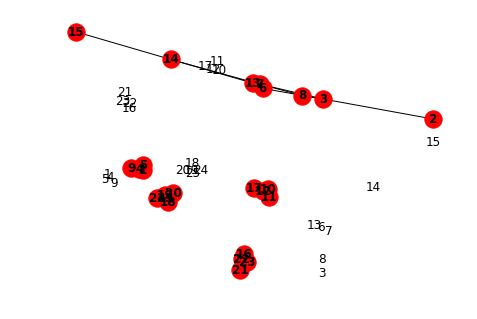

In [14]:
draw_graph(G_req)

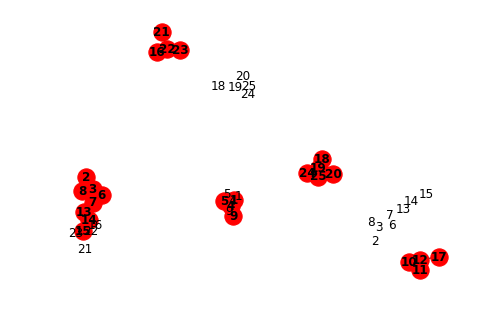

In [15]:
draw_graph(G_prime)

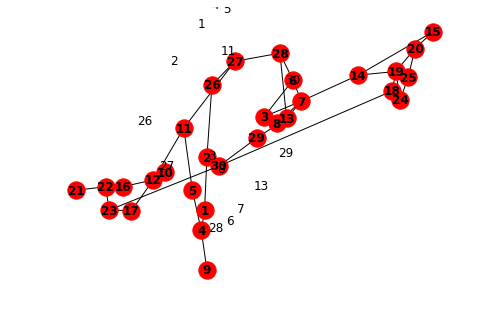

In [16]:
draw_graph(G_all)

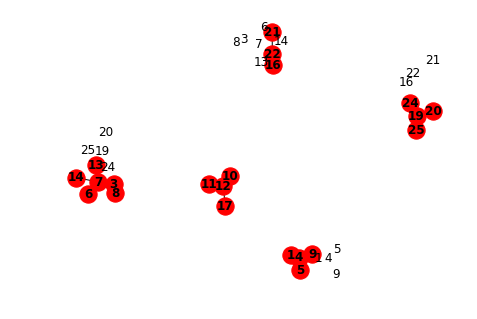

In [17]:
draw_graph(G_req_edges)

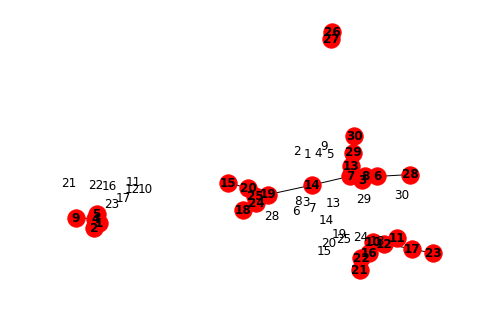

In [18]:
draw_graph(G_all_edges)

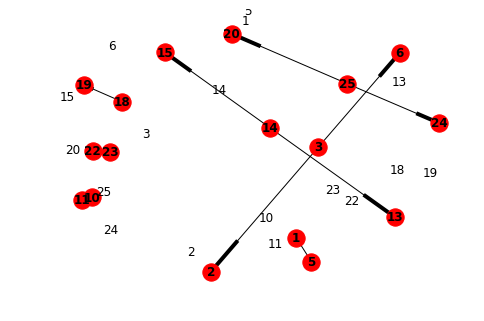

In [19]:
draw_graph(G_req_arcs)

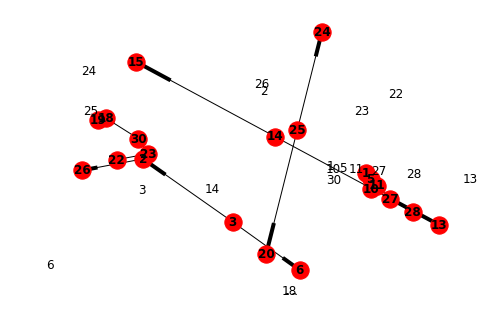

In [20]:
draw_graph(G_all_arcs)

In [21]:
list(G_all_edges.neighbors(1))

[4, 2]

In [22]:
list(G_all_arcs.neighbors(1))

[5]